# Preambule

## libraries

In [1]:
library(tidyverse)
library(stringr)
library(caret)
library(data.table)
library(stringr)
library(dplyr)
library(qs)
library(parallel)
library(randomForest)
library(inTrees)
library(endoR)
library(viridis)
library(ggpubr)
library(parallel)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


qs v0.23.4.

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package

In [2]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/Methanogen_SCFA/Metagenomes_methanogen/envs/r-ml/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggpubr_0.4.0        viridis_0.5.1       viridisLite_0.3.0  
 [4] endoR_0.1.0         inTrees_1.3         randomForest_4.6-14
 [7] qs_0.23.4           data.table_1.13.4   caret_6.0-86       
[10] lattice_0.20-41     forcats_0.5.0       stringr_1.4.0    

## functions

In [3]:
getPR <- function(f, alpha, pi_thr, true_edges, colN){
    res <- qread(f)
    pc <- quiet(stabilitySelection(rules = res$resamp, alpha_error = alpha, pi_thr = pi_thr))
    if (!('edges_agg' %in% names(pc))){return(NA)}
    
    edges <- pc$edges_agg %>% select(x, y, condition, importance, influence, d.x, d.y) %>% 
        subset(condition %in% pc$rules_summary$condition) %>%
        group_by(x, y, condition) %>% 
        summarise(importance= mean(importance), influence = mean(influence*(d.x+d.y)/2)) %>%
        ungroup %>% 
        left_join(select(pc$rules_summary,condition, inN, imp, n), by = 'condition') %>% 
        select(-condition)
    
    edi <- lapply(unique(edges$inN)
                  , function(i, edges, true_edges, colN){
                      suppressMessages(edges <- edges %>% subset(inN >= i) %>% group_by(x, y) %>% 
                                       summarise( inN = max(inN), importance = sum(importance*imp*n)
                                                 , influence = sum(influence*imp*n)/sum(imp*n) ) %>% ungroup)
                      metricsNet(edges = edges, true_edges = true_edges, colN = colN)
                  }, edges = edges, true_edges = true_edges, colN = colN)
    edi <- as.data.frame(do.call(rbind, edi))
    edi$inN <- unique(edges$inN)
    
    edi$N <- str_extract(f, pattern = '(?<=N)[:digit:]+(?=\\_)')
    edi$seedN <- str_extract(f, pattern = '(?<=simu)[:digit:]+(?=\\_)')
    
    return(edi)
}

In [4]:
file.sources <- list.files('./scripts/', pattern = '*.R', full.names=TRUE, ignore.case=TRUE)
for (f in file.sources) {
    source(f)
}
rm('file.sources', 'f')

# Run

In [5]:
true_edges <- qread('true_edges.qs')

In [6]:
tmp <- list.dirs(path = '/ebio/abt3_projects/temp_data/aruaud/', full.names = TRUE)
tmp <- str_subset(tmp, pattern = 'Toy\\_p005\\_N(1|5|2|8|6)[:digit:]+\\_B10$')
tmp

[1] "/ebio/abt3_projects/temp_data/aruaud//Toy_p005_N1000_B10"
[2] "/ebio/abt3_projects/temp_data/aruaud//Toy_p005_N200_B10" 
[3] "/ebio/abt3_projects/temp_data/aruaud//Toy_p005_N500_B10" 
[4] "/ebio/abt3_projects/temp_data/aruaud//Toy_p005_N5000_B10"
[5] "/ebio/abt3_projects/temp_data/aruaud//Toy_p005_N660_B10" 
[6] "/ebio/abt3_projects/temp_data/aruaud//Toy_p005_N800_B10"

In [7]:
fnames <- lapply(tmp, list.files,  full.names = TRUE)
names(fnames) <- tmp

In [8]:
lapply(fnames, length)

$`/ebio/abt3_projects/temp_data/aruaud//Toy_p005_N1000_B10`
[1] 100

$`/ebio/abt3_projects/temp_data/aruaud//Toy_p005_N200_B10`
[1] 100

$`/ebio/abt3_projects/temp_data/aruaud//Toy_p005_N500_B10`
[1] 100

$`/ebio/abt3_projects/temp_data/aruaud//Toy_p005_N5000_B10`
[1] 100

$`/ebio/abt3_projects/temp_data/aruaud//Toy_p005_N660_B10`
[1] 1100

$`/ebio/abt3_projects/temp_data/aruaud//Toy_p005_N800_B10`
[1] 100

In [9]:
# N = 660: I ran too many replicates by mistake (must have missed a 0 when setting the seeds..!)
# just randomly sample 100 replicates 
set.seed(1105)
fnames[['/ebio/abt3_projects/temp_data/aruaud//Toy_p005_N660_B10']] <- sample(fnames[['/ebio/abt3_projects/temp_data/aruaud//Toy_p005_N660_B10']], size = 100, replace = FALSE)
fnames[['/ebio/abt3_projects/temp_data/aruaud//Toy_p005_N660_B10']] %>% length

[1] 100

In [10]:
fnames <- unlist(fnames)

In [11]:
tmp <- qread(fnames[1])
colN <- colnames(tmp$data$x)

In [12]:
#stopCluster(cluster)
cluster <- makeCluster(5)
clusterEvalQ(cluster, library(qs))
clusterEvalQ(cluster, library(endoR))
clusterEvalQ(cluster, library(tidyverse))
clusterExport(cluster, c('getPR', 'metricsNet', 'quiet' ))

[[1]]
[1] "qs"        "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[2]]
[1] "qs"        "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[3]]
[1] "qs"        "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[4]]
[1] "qs"        "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[5]]
[1] "qs"        "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"

[[1]]
[1] "endoR"     "qs"        "stats"     "graphics"  "grDevices" "utils"    
[7] "datasets"  "methods"   "base"     

[[2]]
[1] "endoR"     "qs"        "stats"     "graphics"  "grDevices" "utils"    
[7] "datasets"  "methods"   "base"     

[[3]]
[1] "endoR"     "qs"        "stats"     "graphics"  "grDevices" "utils"    
[7] "datasets"  "methods"   "base"     

[[4]]
[1] "endoR"     "qs"        "stats"     "graphics"  "grDevices" "utils"    
[7] "datasets"  "methods"   "base"     

[[5]]
[1] "endoR"     "qs"        "stats"     "graphics"  "grDevices" "utils"    
[7] "datasets"  "methods"   "base"

[[1]]
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "endoR"     "qs"        "stats"    
[13] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"     

[[2]]
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "endoR"     "qs"        "stats"    
[13] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"     

[[3]]
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "endoR"     "qs"        "stats"    
[13] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"     

[[4]]
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "endoR"     "qs"        "stats"    
[13] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"     

[[5]]
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "ggplot2"   "tidyverse" "endoR"     "qs"        "stats"    
[13] "graphics"  "grDevices" "utils"     "datasets"  "methods"   "base"

In [13]:
test_sev <- parLapply(cl = cluster,fnames, getPR, alpha = 5, pi_thr = 0.7, true_edges = true_edges, colN = colN)

In [14]:
i <- which(sapply(test_sev, class) == 'data.frame')
length(i)
test_sev <- test_sev[i]

[1] 547

In [15]:
test_sev <- do.call(rbind, test_sev)

In [16]:
stopCluster(cluster)

In [17]:
suppressWarnings(av_res <- test_sev %>% group_by(N, inN) %>% summarise_all(mean))

# random

In [18]:
## Total number of edges
N <- (length(colN)*length(colN) - length(colN))/2 
## Total number of correct edges
K <- length(true_edges)

In [19]:
random_pr_curve <- function(i){
  set.seed(i)
  random_draw <- urn[sample(1:N)]
  tp <- cumsum(random_draw)
  fp <- 1:N - cumsum(random_draw)
  linfit <- approx(fp, tp, xout = seq(1, N-K, length.out = 1000),ties = max)
  
  return(do.call(cbind, linfit))
}

In [20]:
## Resample
urn <- c(rep(1, K), rep(0, N-K))
B <- 1000
rdm <- list()
for(j in 1:B){
  rdm[[j]] <- random_pr_curve(j)
}

In [21]:
rdm <- as.data.frame(do.call(rbind, rdm))
colnames(rdm)<- c('fp', 'tp')

In [22]:
rdm <- group_by(rdm, fp) %>% summarise(tp_av = mean(tp), tp_sd = sd(tp), tp_qtiles = quantile(tp, 0.99))

`summarise()` ungrouping output (override with `.groups` argument)



# Interpolate

In [23]:
getInterpo <- function(i, raw){
    raw <- subset(raw, seedN == i)
    res <- list()
    
    i <- 1
    for (a in unique(raw$N)){
        tmp <- approx(raw$fp[raw$N == a]
                       , raw$tp[raw$N == a]
                       , xout = seq(1, N-K, length.out = 1000)
                       , ties = max)
        tmp <- as.data.frame(do.call(cbind, tmp))
        colnames(tmp) <- c('fp', 'tp')
        tmp$N <- a
        
        # add 0 and max values to the extrapolations
        mafp <- max(tmp$fp[!is.na(tmp$tp)])
        tmp$tp[tmp$fp>mafp] <- max(tmp$tp, na.rm = TRUE)

        res[[i]] <- tmp
        i <- i+1
    }
    res <- do.call(rbind, res)
    res$seedN <- i
    
    return(res)
}

In [24]:
pr_byseed <- suppressWarnings(lapply(unique(test_sev$seedN), getInterpo, raw = test_sev))

In [25]:
pr_byseed_av <- do.call(rbind, pr_byseed) %>% select(-seedN) %>% group_by(fp, N) %>% summarise_all(mean)
pr_byseed_sd <- do.call(rbind, pr_byseed) %>% select(-seedN) %>% group_by(fp, N) %>% summarise_all(sd)

pr_forplots <- left_join(pr_byseed_av, pr_byseed_sd, by = c('fp', 'N'), suffix = c('_av', '_sd'))

# check

In [28]:
getRes <- function(f, p = NULL, true_edges){
    tmp <- qread(f)
    p <- str_extract(f, pattern = '(?<=\\_p)[:digit:]+')
        
    # get the new metrics
    quiet(pc <- stabilitySelection(tmp$resamp, alpha_error = 5, pi_thr = 0.7))
    cond <- pc$rules_summary %>% subset(inN >= 7, select = condition) %>% unlist
    if (length(cond) > 0){
            
        imp_edges <- pc$edges_agg %>% subset(condition %in% cond) %>% select(x,y, importance, n, imp)
        imp_edges$x <- str_replace(imp_edges$x, pattern = '\\_{2}.*', replacement = '')
        imp_edges$y <- str_replace(imp_edges$y, pattern = '\\_{2}.*', replacement = '')
        suppressMessages(imp_edges <- imp_edges %>% group_by(x,y) %>% summarise(importance = sum(n*imp*importance)))
        imp_edges <- asplit(as.matrix(imp_edges), MARGIN = 1)
        imp_edges <- lapply(imp_edges, sort) 
        pred_edges <- sapply(imp_edges, function(x){paste(x[-1], collapse = ' - ')}) 
        if(length(pred_edges) == 0){
            return(c('p' = p, 'rf_accuracy' = tmp$rf_accuracy, 'n_decisions' = 0
                , 'tp_imp' = 0, 'fp_imp' = 0, 'tp' = 0, 'fp' = 0, 'fn' = 0))
        }

        # those that should not be but are = in pred_edges but not truth
        tp <- which(sapply(pred_edges, function(x){x %in% true_edges}))
        fp <- which(sapply(pred_edges, function(x){!(x %in% true_edges)}))
        fn <- sum(sapply(true_edges, function(x){!(x %in% pred_edges)}))

        # sum of FP importances
        if(length(fp) > 0) {
            fp_imp <- sum(sapply(imp_edges[fp], function(x){as.numeric(x['importance'])}))
        } else {fp_imp <- 0}
        # sum of TP importances
        if(length(tp) > 0) {
            tp_imp <- sum(sapply(imp_edges[tp], function(x){as.numeric(x['importance'])}))
        } else {tp_imp <- 0}

        res <- c('p' = p, 'rf_accuracy' = tmp$rf_accuracy, 'n_decisions' = length(cond)
                , 'tp_imp' = tp_imp, 'fp_imp' = fp_imp, 'tp' = length(tp), 'fp' = length(fp)
                , 'fn' = fn)
    } else {
        res <- c('p' = p, 'rf_accuracy' = tmp$rf_accuracy, 'n_decisions' = 0
                , 'tp_imp' = 0, 'fp_imp' = 0, 'tp' = 0, 'fp' = 0, 'fn' = 0)
    }
    
    return(res)
}

In [27]:
true_edges <- qread('true_edges.qs')
true_edges <- true_edges %>% lapply(str_replace, pattern = '\\_{2}.*', replacement = '') %>% 
                unique %>% lapply(sort) %>% 
                sapply(paste, collapse = ' - ')

In [29]:
suppressMessages(check <- sapply(fnames, getRes, true_edges = true_edges))

Warning message in stabilitySelection(tmp$resamp, alpha_error = 5, pi_thr = 0.7):
“No stable decision ensemble could be reached: try increasing alpha.”
Warning message in stabilitySelection(tmp$resamp, alpha_error = 5, pi_thr = 0.7):
“No stable decision ensemble could be reached: try increasing alpha.”
Warning message in stabilitySelection(tmp$resamp, alpha_error = 5, pi_thr = 0.7):
“No stable decision ensemble could be reached: try increasing alpha.”
Warning message in stabilitySelection(tmp$resamp, alpha_error = 5, pi_thr = 0.7):
“No stable decision ensemble could be reached: try increasing alpha.”
Warning message in stabilitySelection(tmp$resamp, alpha_error = 5, pi_thr = 0.7):
“No stable decision ensemble could be reached: try increasing alpha.”
Warning message in stabilitySelection(tmp$resamp, alpha_error = 5, pi_thr = 0.7):
“No stable decision ensemble could be reached: try increasing alpha.”
Warning message in stabilitySelection(tmp$resamp, alpha_error = 5, pi_thr = 0.7):
“No st

In [ ]:
check <- as.data.frame(t(check))
check$N <- str_extract(rownames(check), pattern = '[:digit:]+(?=\\_B)') %>% as.numeric
check$p <- 0.05
check <- check %>% mutate_all(as.numeric)

In [ ]:
check$precision <- check$tp/(check$tp+check$fp)
check$recall <- check$tp/(check$tp+check$fn)
check$w_precision <- check$tp_imp/(check$tp_imp+check$fp_imp)

In [43]:
check %>% group_by(N) %>% summarise_all(mean, na.rm = TRUE) %>% 
select(N, rf_accuracy, n_decisions, tp, fp, fn, tp_imp, fp_imp, precision, recall, w_precision) 

N,rf_accuracy,n_decisions,tp,fp,fn,tp_imp,fp_imp,precision,recall,w_precision
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
200,0.679550,0.85,0.76,0.52,5.44,7.371502,0.6143712,0.7891321,0.1225806,0.8328305
500,0.764720,2.06,2.30,1.71,6.90,25.495941,1.1436344,0.7204381,0.2500000,0.9147154
660,0.766040,2.10,2.46,1.45,6.64,23.825879,0.9564652,0.7652663,0.2703297,0.9275854
800,0.810575,4.78,4.54,4.20,5.46,39.329230,3.9671471,0.5959556,0.4540000,0.8910415
1000,0.833440,5.81,5.31,5.24,4.69,42.086573,5.3772004,0.5767208,0.5310000,0.8648359
5000,0.924990,10.51,9.87,9.88,0.14,20.179236,1.8341602,0.5486049,0.9860000,0.9265236


In [44]:
check %>% group_by(N) %>% summarise_all(sd, na.rm = TRUE) %>% #subset(N != 1000) %>% 
select(N, rf_accuracy, n_decisions, tp, fp, fn, tp_imp, fp_imp, precision, recall, w_precision) 

N,rf_accuracy,n_decisions,tp,fp,fn,tp_imp,fp_imp,precision,recall,w_precision
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
200,0.040985924,0.857233,0.8659671,1.243001,4.3259144,10.072174,2.127240,0.3629045,0.07979349,0.33482037
500,0.024341875,1.369362,1.7950549,2.375357,2.6342729,19.541650,1.804785,0.3231100,0.17320508,0.15212478
660,0.025777572,1.459902,1.8554860,2.194460,2.6912503,20.614703,1.666830,0.2830856,0.17669466,0.13967211
800,0.018964197,2.307563,2.0519515,4.099766,2.0519515,25.555485,4.344745,0.2685530,0.20519515,0.11852793
1000,0.016621952,2.676856,2.1959329,4.653922,2.1959329,27.084059,4.954113,0.2724472,0.21959329,0.12086530
5000,0.004457872,2.245062,0.3666667,5.939561,0.3487351,7.084747,1.625525,0.1761171,0.03487351,0.05488979


In [45]:
check[ complete.cases(check), ] %>% subset(N == 660) %>% unique %>% nrow

[1] 91

In [46]:
check[ complete.cases(check), ] %>% count(N)

N,n
<dbl>,<int>
200,62
500,92
660,91
800,100
1000,100
5000,100


# plots

Results for N = 660 are not shown in the manuscript since the plot looks crowded. But they were run, so let's plot them anyway!

In [26]:
cols <- plasma(length(unique(av_res$N)) + 2)

In [27]:
p <- ggplot(pr_forplots 
             , aes(x = fp, y = tp_av, group = as.character(N), color = as.character(N)))+
geom_hline(yintercept = 10, color = 'lightgrey', linetype = 'dashed')+
geom_line(data = pr_forplots , size = 1)+

geom_ribbon(aes(ymin = tp_av - tp_sd/2, ymax = tp_av + tp_sd/2
                , group = N, fill = as.character(N)), color = NA
            , alpha = 0.25) +

geom_line(data = rdm, aes(y = tp_av, x = fp), group=NA, color = 'darkgrey')+
geom_ribbon(data = rdm
            , aes(ymin = tp_av - tp_sd/2, ymax = tp_av + tp_sd/2, y = tp_av
                  , group=NULL, color = NULL)
            , alpha = 0.25, fill = 'darkgrey') +

geom_point(data = av_res %>% subset(inN == 7)
           , aes(y = tp, x = fp, fill = as.character(N))
           , size = 4, shape = 21, color = 'black')+


theme_classic()+
labs(x = 'Number of FP', y = 'Number of TP')+
scale_color_manual(values = cols[-c(1, length(cols))], name = 'n', breaks =  c('200', '500', '660', '800', '1000', '5000')) +
scale_fill_manual(values = cols[-c(1, length(cols))], name = 'n', breaks =  c('200','500', '660', '800','1000', '5000')) 

Warning message:
“Removed 306 row(s) containing missing values (geom_path).”


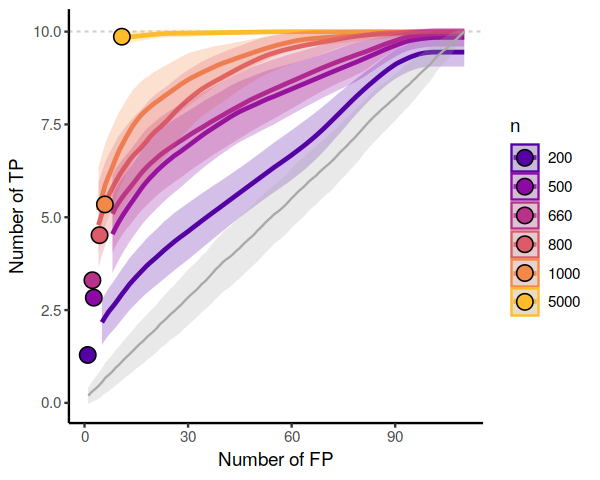

In [28]:
options(repr.plot.width=5, repr.plot.height=4)
p

In [31]:
p_acc <- ggplot(check %>% subset( N != 660)
                , aes(x = rf_accuracy, y = w_precision,color = as.character(N)))+

geom_point(size = 3, alpha = 0.5)+

geom_point(data = tmp_av %>% subset( N != 660), size = 5, alpha = 1, shape = 21, color = 'white', fill = 'black')+
geom_point(data = tmp_av %>% subset( N != 660)
           , aes(y = w_precision, x = rf_accuracy, fill = as.character(N))
           , size = 4, shape = 21, color = 'black')+

theme_classic()+ 
scale_color_manual(values = cols[-c(1, length(cols))]
                   , name = 'n', breaks =  c('200', '500', '800', '1000', '5000')
                  , guide = guide_legend(override.aes = list(alpha = .8) ) ) +
                   
scale_fill_manual(values = cols[-c(1, length(cols))]
                  , name = 'n', breaks =  c('200','500', '800','1000', '5000')
                 , guide = 'none')+
labs(x = 'RF accuracy', y = 'Weighted precision')

ERROR: Error in subset(., N != 660): object 'check' not found


In [32]:
options(repr.plot.width=5, repr.plot.height=4)
p_acc

ERROR: Error in eval(expr, envir, enclos): object 'p_acc' not found
